In [1]:
!pip install "gymnasium[toy-text]"


In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import torch
import os
from datetime import datetime
import pickle
import io

env = gym.make("FrozenLake-v1", render_mode="rgb_array")
q_table = None
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [12]:
def visualize_agent(env, q_table, episodes=5, sleep_time=0.5, end_sleep_time=2):
    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.axis('off')
            plt.show()
            sleep(sleep_time)

            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)

        clear_output(wait=True)
        plt.imshow(env.render())
        plt.axis('off')
        plt.show()
        sleep(end_sleep_time)

In [13]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [14]:

# Prepare model saving directories
model_root = "models"
if not os.path.exists(model_root):
    os.makedirs(model_root, exist_ok=True)
try:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
except Exception as e:
    print(f"Error generating timestamp: {e}")
    timestamp = "default_timestamp"
# Load the most recent q_table, ep_num, epsilon, and rewards_per_episode if they exist
latest_data = None
timestamps = [d for d in os.listdir(model_root) if os.path.isdir(os.path.join(model_root, d))]
if timestamps:
    latest_timestamp = max(timestamps)
    latest_run_dir = os.path.join(model_root, latest_timestamp)
    dump_files = [f for f in os.listdir(latest_run_dir) if f.endswith(".pkl") or f.endswith(".pt")]
    if dump_files:
        latest_dump_file = max(dump_files, key=lambda x: int(x.split('_')[1]))
        latest_dump_path = os.path.join(latest_run_dir, latest_dump_file)
        if latest_dump_path.endswith(".pkl"):
            with open(latest_dump_path, "rb") as f:
                # latest_data = pickle.load(f)
                latest_data = CPU_Unpickler(f).load()
        elif latest_dump_path.endswith(".pt"):
            with open(latest_dump_path, "rb") as f:
                # latest_data = torch.load(latest_dump_path, map_location=device, weights_only=False)
                latest_data = torch.load(latest_dump_path, map_location=torch.device('cpu'), weights_only=False)

if latest_data is not None:
    q_table = latest_data.get("q_table", q_table)
    ep_num = latest_data.get("ep_num", 0)
    epsilon = latest_data.get("epsilon", None)
    rewards_per_episode = latest_data.get("rewards_per_episode", [])
    conversation_history_ids = latest_data.get("conversation_history_ids", None)
    print(f"Loaded data from {latest_dump_path}")
else:
    print("No previous data found. Starting fresh.")

Loaded data from models/2025-04-26_20-02-58/ep_800_stats.pkl


In [17]:
def print_q_table(q_table, env):
    """Prints the Q-table in a readable format using pandas DataFrame."""
    actions = ['Left', 'Down', 'Right', 'Up']
    df = pd.DataFrame(q_table, columns=actions)
    df.index.name = 'State'

    print("\n===== Q-Table =====")
    print(df.round(2))  # Round to 2 decimal places for readability
    print("===================\n")

print_q_table(q_table, env)


===== Q-Table =====
        Left   Down  Right     Up
State                            
0      16.93  16.86  16.84  17.00
1      14.85   8.98   4.60  17.00
2      17.00  16.58   9.05  17.00
3       7.03   6.65   8.03  17.00
4      16.92   5.06  15.20   7.38
5       0.00   0.00   0.00   0.00
6       1.74   1.27   1.83   2.43
7       0.00   0.00   0.00   0.00
8      10.39   7.85  12.46  16.15
9       6.35  13.28  12.80   3.48
10      9.61   6.97   4.41   7.03
11      0.00   0.00   0.00   0.00
12      0.00   0.00   0.00   0.00
13      5.36  12.51  15.73   8.07
14     14.45   0.87   5.79   5.18
15      0.00   0.00   0.00   0.00



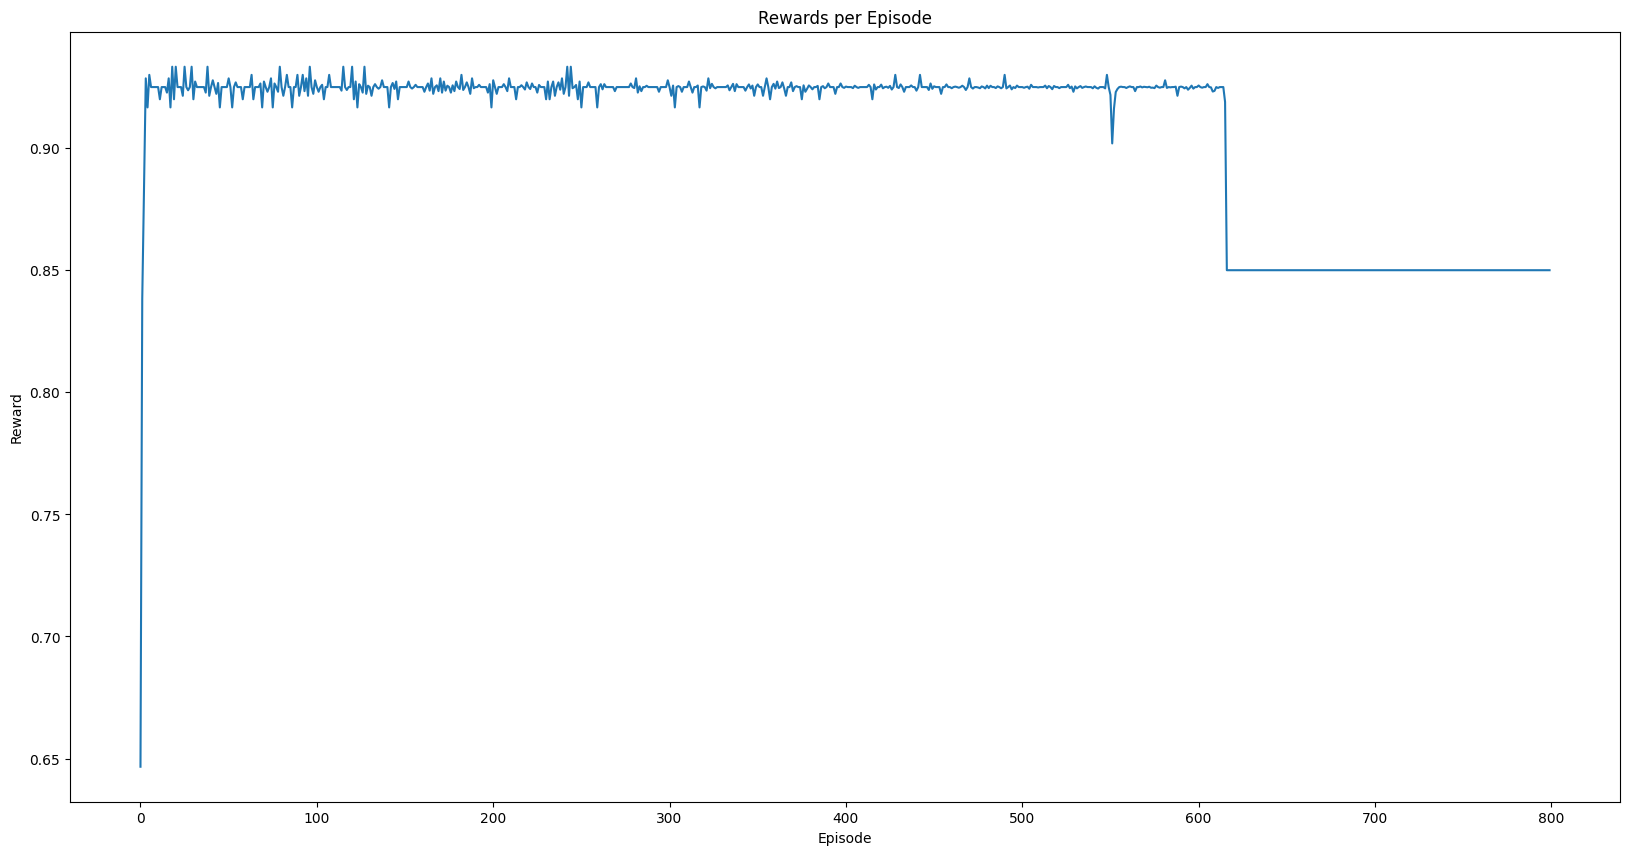

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(rewards_per_episode)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [16]:
env.reset()
# Visualize the agent's performance
visualize_agent(env, q_table, episodes=1, sleep_time=0, end_sleep_time=3)

#Clean up the environment
env.close()

KeyboardInterrupt: 